In [2]:
import argparse
import random
import math
import sys
import cv2
import os

import tensorflow        as tf
import numpy             as np
import matplotlib.pyplot as plt

from fcnvgg import FCNVGG
from utils  import *
from glob   import glob
from tqdm   import tqdm

# Imports from demo.py in Udacity Workspace
import sys, skvideo.io, json, base64
import numpy as np
from PIL import Image
from io  import BytesIO, StringIO

%load_ext autotime


c:\programdata\anaconda3\envs\spaces\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
def sample_generator(video, image_size=(416,320), batch_size=5):
    for offset in range(0, len(video), batch_size):
        files = video[offset:offset+batch_size]
        images = []
        names = []
        for frame in video:
            image = cv2.resize(frame, image_size)
            images.append(image.astype(np.float32))
            #names.append(os.path.basename(image_file))
        yield np.array(images)

def encode(array):
	pil_img = Image.fromarray(array)
	buff = BytesIO()
	pil_img.save(buff, format="PNG")
	return base64.b64encode(buff.getvalue()).decode("utf-8")

time: 20 ms


In [4]:
parser = argparse.ArgumentParser(description='Generate data based on a model')
parser.add_argument('--name', default='test',
                    help='project name')
parser.add_argument('--checkpoint', type=int, default=-1,
                    help='checkpoint to restore; -1 is the most recent')
parser.add_argument('--video-file', default='test',
                    help='video file to analyze')
parser.add_argument('--output-dir', default='test-output',
                    help='directory for the resulting images')
parser.add_argument('--batch-size', type=int, default=10,
                    help='batch size')
parser.add_argument('--data-source', default='carla',
                    help='data source')

args = parser
args.name        = 'runs\\t3'
args.checkpoint  = -1
args.video_file  = 'test_video.mp4'
args.output_dir  = 'test_output'
args.batch_size  = 1
args.data_source = 'carla'

time: 24 ms


In [5]:
state = tf.train.get_checkpoint_state(args.name)
if state is None:
    print('[!] No network state found in ' + args.name)
    sys.exit(1)

try:
    checkpoint_file = state.all_model_checkpoint_paths[args.checkpoint]
    print("Loaded checkpoint: {0}".format(checkpoint_file))
except IndexError:
    print('[!] Cannot find checkpoint ' + str(args.checkpoint_file))
    sys.exit(1)

metagraph_file = checkpoint_file + '.meta'

if not os.path.exists(metagraph_file):
    print('[!] Cannot find metagraph ' + metagraph_file)
    sys.exit(1)
else:
    print('Loaded metagraph:  {0}'.format(metagraph_file))


Loaded checkpoint: runs\t3\final.ckpt
Loaded metagraph:  runs\t3\final.ckpt.meta
time: 45 ms


In [6]:
try:
    source       = load_data_source(args.data_source)
    label_colors = source.label_colors
except (ImportError, AttributeError, RuntimeError) as e:
    print('[!] Unable to load data source:', str(e))
    sys.exit(1)

time: 10 ms


In [7]:
video = skvideo.io.vread(args.video_file)


time: 2.13 s


In [8]:
np.shape(video)
source.image_size

(416, 320)

time: 4.01 ms


In [25]:
global imgs
global img_labels
with tf.Session() as sess:
    print('[i] Creating the model...')
    net = FCNVGG(sess)
    net.build_from_metagraph(metagraph_file, checkpoint_file)

    #---------------------------------------------------------------------------
    # Process the images
    #---------------------------------------------------------------------------
    #generator = sample_generator(video, source.image_size, args.batch_size)
    generator = sample_generator(video)

    n_sample_batches = int(math.ceil(len(video)/args.batch_size))
    description = '[i] Processing video'

    for x in tqdm(generator, total=n_sample_batches, desc=description, unit='batches'):
        feed = {net.image_input:  x,
                net.keep_prob:    1}
        img_labels = sess.run(net.classes, feed_dict=feed)

        #binary_car_result = np.where()
        imgs = draw_labels_batch(x, img_labels, label_colors, False)
        
     

[i] Creating the model...
INFO:tensorflow:Restoring parameters from runs\t3\final.ckpt


[i] Processing video:  23%|██████████▊                                     | 7/31 [00:09<00:31,  1.33s/batches]


time: 17.3 s


In [10]:
for i in range(3):
        cv2.imwrite('testtt' + '/' + str(random.randint(1,10001)), imgs[i, :, :, :])


error: OpenCV(3.4.1) D:\Build\OpenCV\opencv-3.4.1\modules\imgcodecs\src\loadsave.cpp:678: error: (-2) could not find a writer for the specified extension in function cv::imwrite_


time: 228 ms


In [ ]:
np.shape(imgs)

In [16]:
cv2.imshow('ya',imgs[2,:,:,:])
cv2.waitKey(1)

-1

time: 18 ms


In [12]:
import cv2
cv2.imwrite("d:/data", imgs[2,:,:,:])

error: OpenCV(3.4.1) D:\Build\OpenCV\opencv-3.4.1\modules\imgcodecs\src\loadsave.cpp:678: error: (-2) could not find a writer for the specified extension in function cv::imwrite_


time: 12 ms


In [17]:
testtt = imgs[2,:,:,:]

time: 0 ns


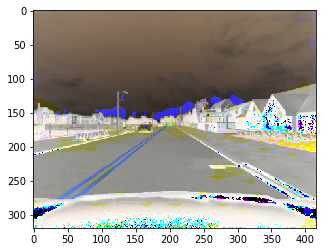

time: 369 ms


In [24]:
plt.imshow(testtt)

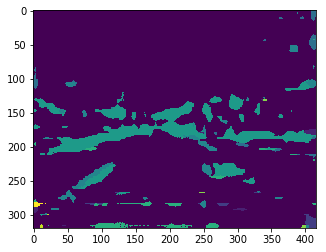

time: 202 ms


In [32]:
test = img_labels[2]

plt.imshow(test)

In [37]:
for x in (np.unique(test, return_counts=True)):
    print(x)

[ 0  1  2  4  5  6  7  9 10 11]
[118385    255    411    695   1889  10075   1246     64     26     74]
time: 7.01 ms
